In [1]:

# =====================
# 1. Setup and Imports
# =====================
!pip install numpy pandas scikit-learn keras tensorflow matplotlib seaborn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from google.colab import files

In [2]:
# =====================
# 2. Upload and Load Dataset
# =====================
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, low_memory=False)

# Clean non-numeric columns
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            df[col] = pd.factorize(df[col])[0]

print("Dataset shape:", df.shape)
print(df.head())

Saving auslan_dataset.csv to auslan_dataset.csv
Dataset shape: (2565, 2995)
   label  instance_id  n_frames        f0        f1        f2        f3  \
0      0            0        53 -0.145190 -0.134012 -0.042625  0.628886   
1      1            0        64 -0.147735 -0.142049 -0.048027  0.630558   
2      2            1        72 -0.092146 -0.117536 -0.054814  0.487353   
3      3            1        50 -0.139162  0.022173 -0.049903  0.443529   
4      4            1        50 -0.153405 -0.007877 -0.058475  0.446226   

         f4        f5        f6  ...  f2982  f2983  f2984  f2985  f2986  \
0  0.181777  0.445363  0.014227  ...    NaN    NaN    NaN    NaN    NaN   
1  0.195083  0.431190  0.243467  ...    NaN    NaN    NaN    NaN    NaN   
2  0.420042  0.519053  0.587997  ...    NaN    NaN    NaN    NaN    NaN   
3  0.495801  0.551219  0.786403  ...    NaN    NaN    NaN    NaN    NaN   
4  0.526392  0.489199  0.207942  ...    NaN    NaN    NaN    NaN    NaN   

   f2987  f2988  f2989

In [3]:
# =====================
# 3. Preprocessing
# =====================
if 'label' not in df.columns:
    raise ValueError("Dataset must have a 'label' column.")

X = df.drop('label', axis=1).fillna(0).values
y = df['label'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Baseline Model Results:
                      Accuracy  Precision    Recall        F1
SVM_linear           0.883117   0.902355  0.883117  0.883784
SVM_rbf              0.348052   0.371600  0.348052  0.306630
Logistic_Regression  0.864935   0.884388  0.864935  0.865827


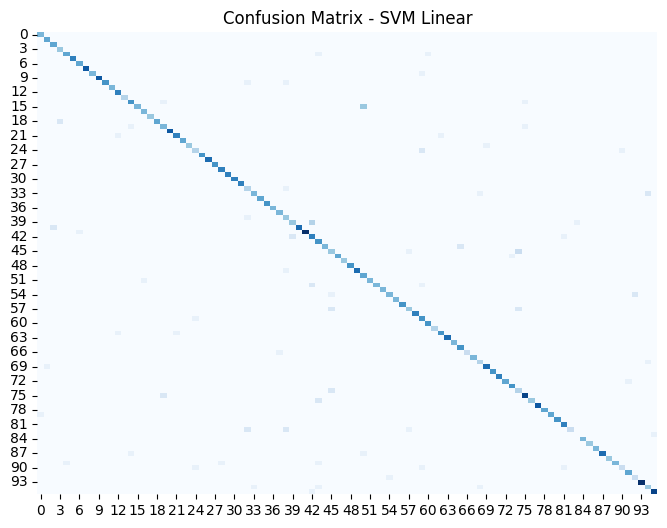

In [4]:
# =====================
# 4. Baseline Models (SVM + Logistic Regression)
# =====================
models = {
    'SVM_linear': SVC(kernel='linear'),
    'SVM_rbf': SVC(kernel='rbf'),
    'Logistic_Regression': LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

results_df = pd.DataFrame(results).T
print("\nBaseline Model Results:\n", results_df)

# Confusion Matrix for SVM (Linear)
y_pred_svm = models['SVM_linear'].predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM Linear')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


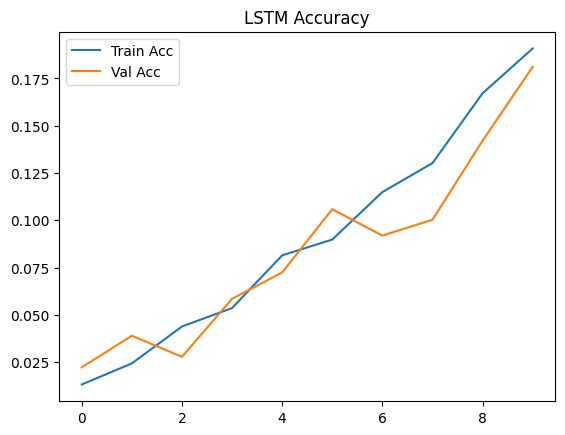

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [6]:
# =====================
# 5. LSTM Model
# =====================
X_seq = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y, test_size=0.3, random_state=42)

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train_seq.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(len(np.unique(y)), activation='softmax'))

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('LSTM Accuracy')
plt.show()

lstm_preds = np.argmax(lstm_model.predict(X_test_seq), axis=1)
results['LSTM'] = {
    'Accuracy': accuracy_score(y_test_seq, lstm_preds),
    'Precision': precision_score(y_test_seq, lstm_preds, average='weighted', zero_division=0),
    'Recall': recall_score(y_test_seq, lstm_preds, average='weighted', zero_division=0),
    'F1': f1_score(y_test_seq, lstm_preds, average='weighted', zero_division=0)
}


In [5]:

# =====================
# 6. Sequential Pattern Mining (Simplified - Fixed)
# =====================
def discretize_signal(values, bins=['L', 'M', 'H']):
    thresholds = np.quantile(values, [0.33, 0.66])
    discrete = []
    for v in values:
        if v < thresholds[0]:
            discrete.append('L')
        elif v < thresholds[1]:
            discrete.append('M')
        else:
            discrete.append('H')
    return discrete

# Create discretized version of all features
X_disc = np.array([discretize_signal(X_scaled[:, i]) for i in range(X_scaled.shape[1])]).T

# Convert discretized signals into numerical pattern counts per sample
X_spm = np.zeros((X_scaled.shape[0], X_scaled.shape[1]))
for i in range(X_scaled.shape[0]):
    for j in range(X_scaled.shape[1]):
        val = X_disc[i, j]
        if val == 'L':
            X_spm[i, j] = 0.2
        elif val == 'M':
            X_spm[i, j] = 0.5
        else:
            X_spm[i, j] = 0.8

X_train_spm, X_test_spm, y_train_spm, y_test_spm = train_test_split(X_spm, y, test_size=0.3, random_state=42)

spm_model = SVC(kernel='linear')
spm_model.fit(X_train_spm, y_train_spm)
y_pred_spm = spm_model.predict(X_test_spm)

results['SPM'] = {
    'Accuracy': accuracy_score(y_test_spm, y_pred_spm),
    'Precision': precision_score(y_test_spm, y_pred_spm, average='weighted', zero_division=0),
    'Recall': recall_score(y_test_spm, y_pred_spm, average='weighted', zero_division=0),
    'F1': f1_score(y_test_spm, y_pred_spm, average='weighted', zero_division=0)
}

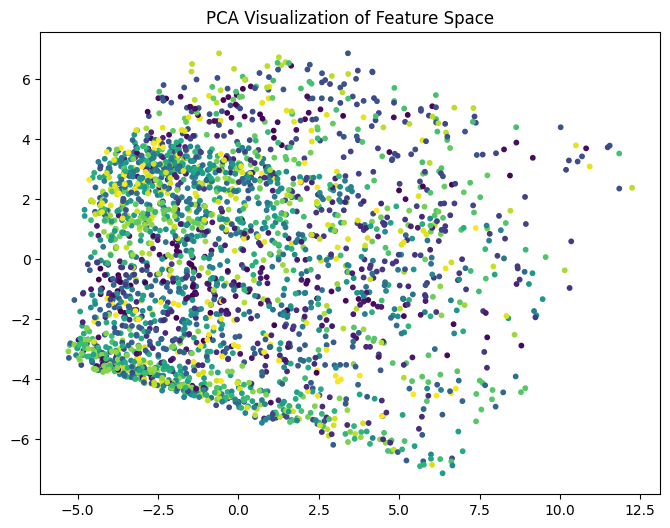

In [7]:
# =====================
# 7. PCA Visualization
# =====================
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=pd.factorize(y)[0], cmap='viridis', s=10)
plt.title('PCA Visualization of Feature Space')
plt.show()


In [8]:
# =====================
# 8. Final Results Summary
# =====================
results_df = pd.DataFrame(results).T
print("\nFinal Model Comparison:\n", results_df)



Final Model Comparison:
                      Accuracy  Precision    Recall        F1
SVM_linear           0.883117   0.902355  0.883117  0.883784
SVM_rbf              0.348052   0.371600  0.348052  0.306630
Logistic_Regression  0.864935   0.884388  0.864935  0.865827
SPM                  0.874026   0.893221  0.874026  0.875095
LSTM                 0.184416   0.123629  0.184416  0.116397
